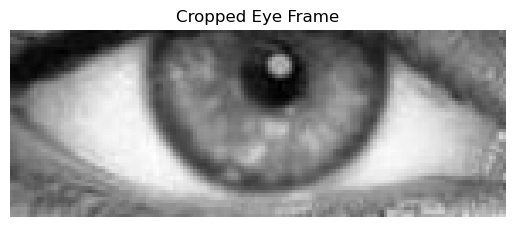

Optimal Threshold: 85


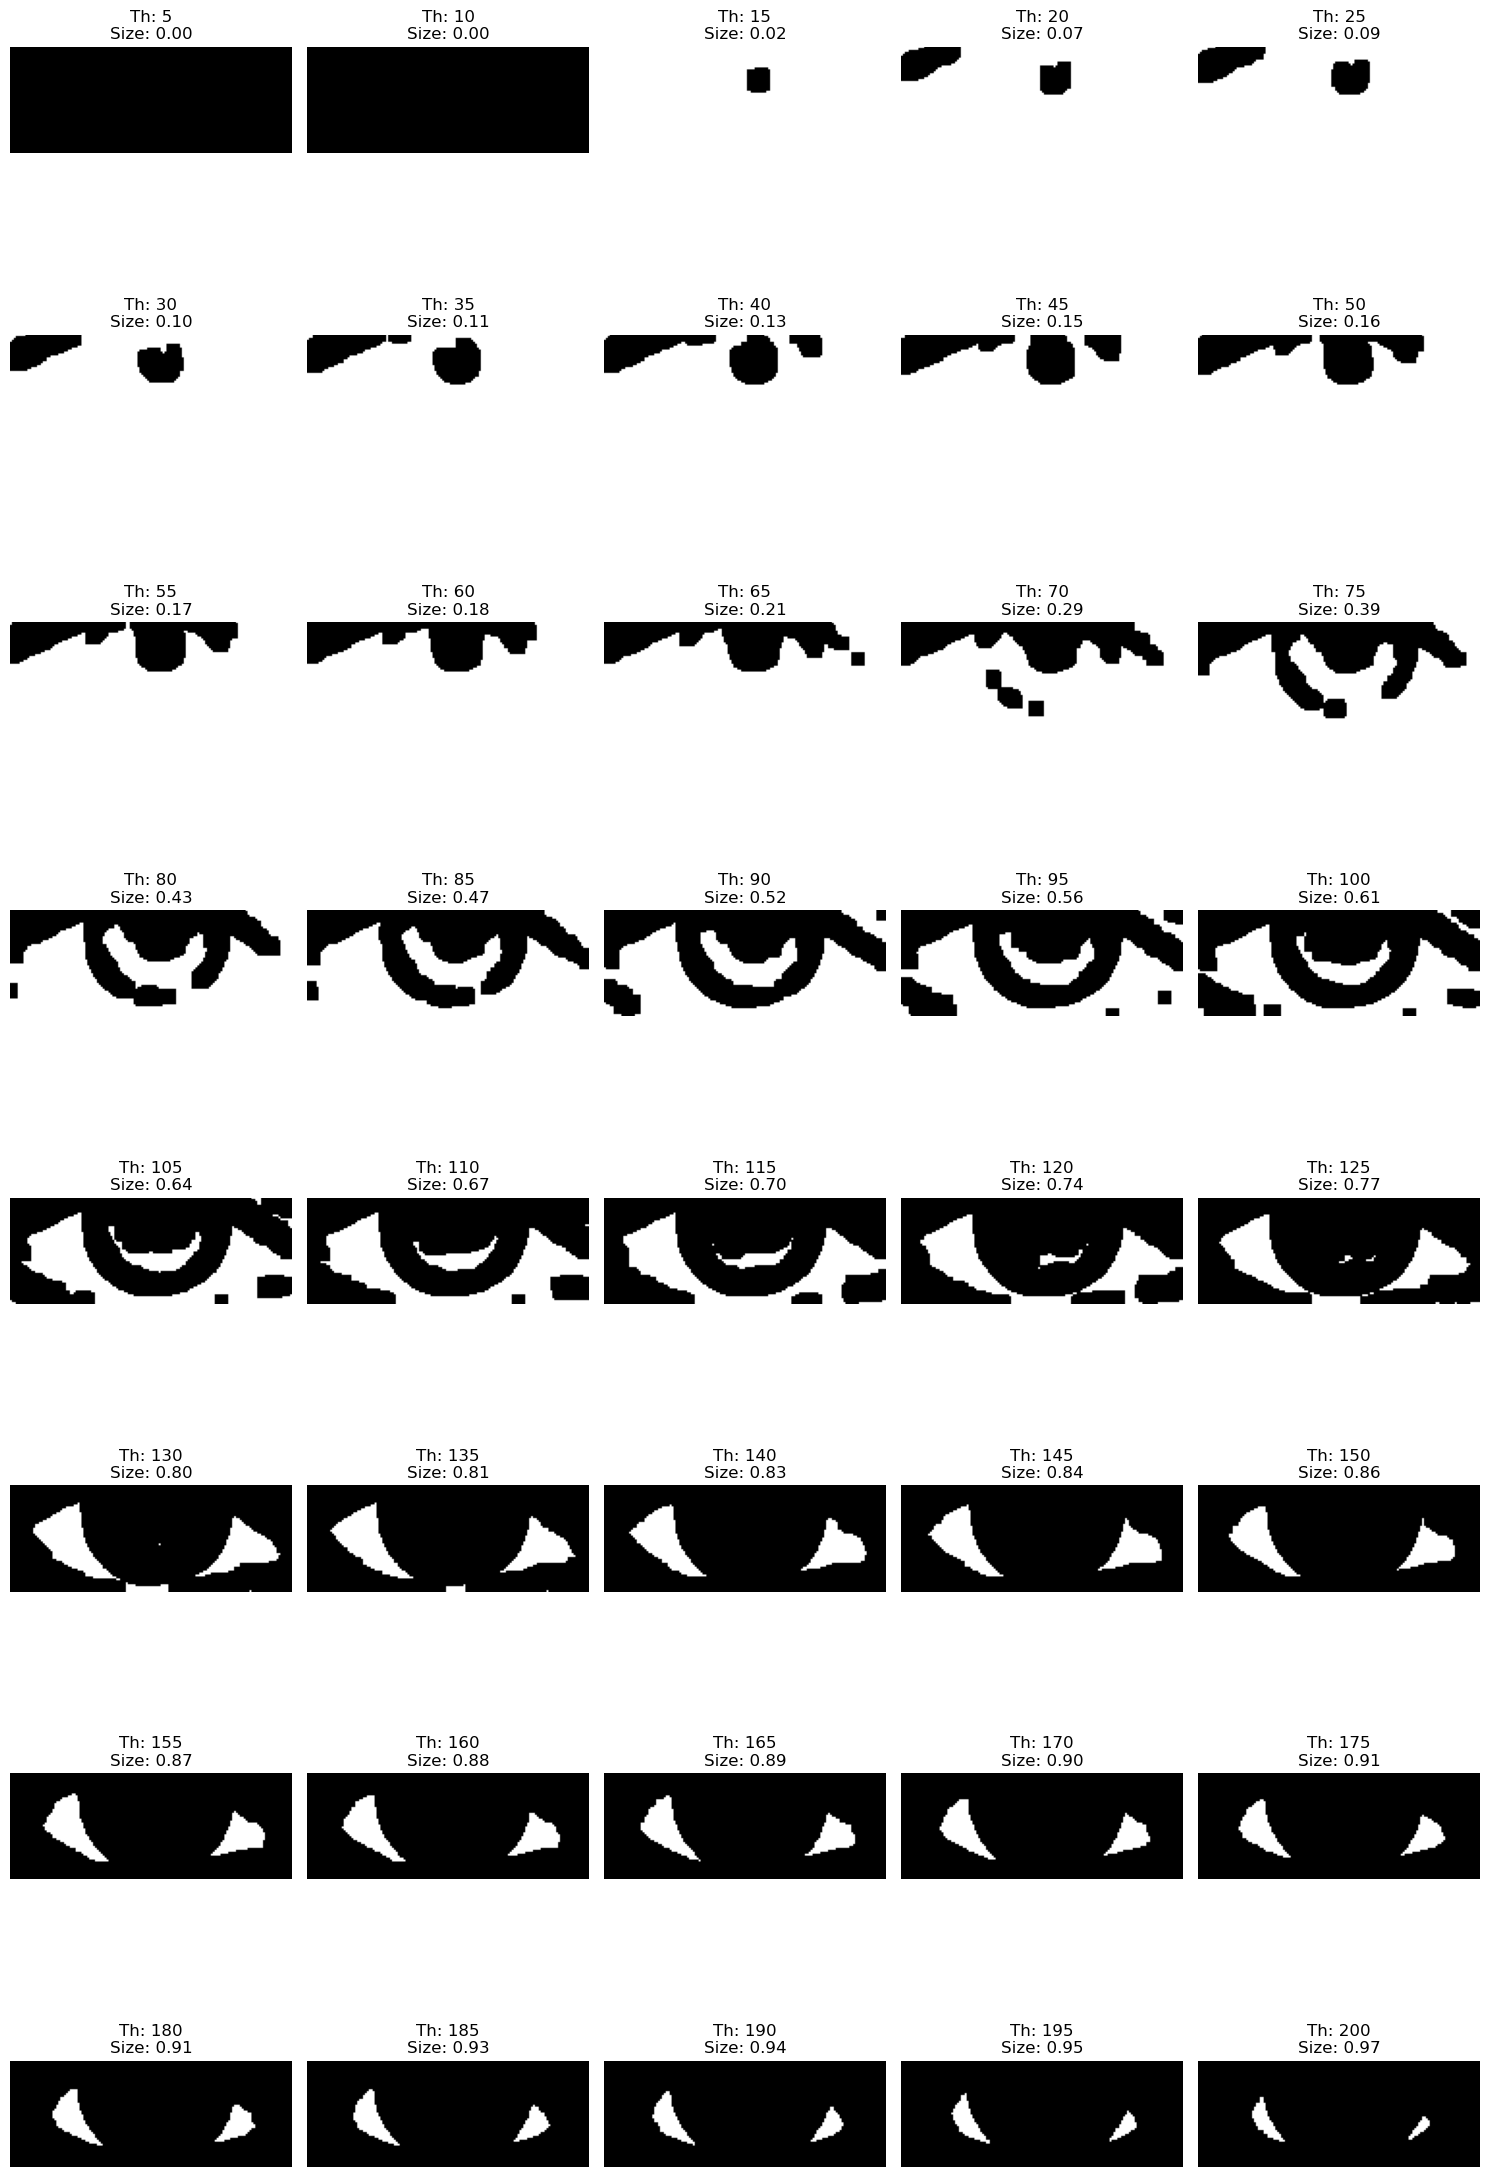

Optimal Threshold for eye frame: 85


In [2]:
import numpy as np
import cv2
import dlib
import matplotlib.pyplot as plt


predictor_path = "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

class Calibration:
    @staticmethod
    def calculate_iris_occupancy(frame):
        frame = frame[5:-5, 5:-5]
        height, width = frame.shape[:2]
        nb_pixels = height * width
        nb_blacks = nb_pixels - cv2.countNonZero(frame)  # Count black pixels
        return nb_blacks / nb_pixels  # Return the proportion of black pixels

class Pupil:
    @staticmethod
    def image_processing(eye_frame, threshold):
        """Performs operations on the eye frame to isolate the iris"""
        kernel = np.ones((3, 3), np.uint8)
        new_frame = cv2.bilateralFilter(eye_frame, 10, 15, 15)
        new_frame = cv2.erode(new_frame, kernel, iterations=3)
        new_frame = cv2.threshold(new_frame, threshold, 255, cv2.THRESH_BINARY)[1]
        return new_frame

def find_best_threshold(eye_frame):
    """Calculates the optimal threshold to binarize the frame for the given eye."""
    average_iris_size = 0.48  # Target size for the iris occupancy
    trials = {}

    # Adjusting to fit all 40 thresholds
    fig, axes = plt.subplots(8, 5, figsize=(15, 24))  # Now accommodates 40 subplots
    axes = axes.ravel()

    for i, threshold in enumerate(range(5, 205, 5)):  # Now includes threshold 200
        iris_frame = Pupil.image_processing(eye_frame, threshold)

        if iris_frame is None or iris_frame.size == 0:
            print(f"Error: iris_frame is empty at threshold {threshold}")
            continue

        iris_size = Calibration.calculate_iris_occupancy(iris_frame)
        trials[threshold] = iris_size

        # Display each thresholded image with calculated iris size
        axes[i].imshow(iris_frame, cmap='gray')
        axes[i].set_title(f"Th: {threshold}\nSize: {iris_size:.2f}")
        axes[i].axis('off')

    # Avoid errors if trials are empty
    if trials:
        best_threshold, _ = min(trials.items(), key=lambda p: abs(p[1] - average_iris_size))
        print(f"Optimal Threshold: {best_threshold}")
    else:
        print("No valid thresholds found.")
        best_threshold = None

    plt.tight_layout()
    plt.show()
    
    return best_threshold

# Detect and extract eye frame
def get_eye_frame_from_face(face_image):
    faces = detector(face_image, 1)
    if len(faces) == 0:
        return None

    landmarks = predictor(face_image, faces[0])
    left_eye_points = landmarks.parts()[36:42]  # Assuming left eye landmark points
    x_min = min(point.x for point in left_eye_points)
    x_max = max(point.x for point in left_eye_points)
    y_min = min(point.y for point in left_eye_points)
    y_max = max(point.y for point in left_eye_points)

    eye_frame = face_image[y_min:y_max, x_min:x_max]
    
    plt.imshow(eye_frame, cmap='gray')
    plt.title("Cropped Eye Frame")
    plt.axis('off')
    plt.show()
    
    return eye_frame


image_path = "face.png"
face_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
eye_frame = get_eye_frame_from_face(face_image)

if eye_frame is not None:
    optimal_threshold = find_best_threshold(eye_frame)
    print(f"Optimal Threshold for eye frame: {optimal_threshold}")
else:
    print("No eye detected.")
